<a href="https://colab.research.google.com/github/rtegao/M5Forecasting/blob/master/MultiFeature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler

# Functions

In [0]:
def normalizing_data(df_train,df_val,df_test):
  try:
    data_list = [df_train.copy(),df_val.copy(),df_test.copy()]
    min_list = df_train.min(axis=0)
    max_list = df_train.max(axis=0)
    for j in range(len(data_list)):
      for i in range(df_train.shape[1]):
        data_list[j].iloc[:,i] = (data_list[j].iloc[:,i]-min_list[i])/abs((min_list[i]-max_list[i]))
      data_list[j]=data_list[j].values
  except:
    df_train = df_train.values.reshape(-1,1)
    df_val = df_val.values.reshape(-1,1)
    df_test = df_test.values.reshape(-1,1)

    data_list = [df_train.copy(),df_val.copy(),df_test.copy()]
    min_list = df_train.min(axis=0)
    max_list = df_train.max(axis=0)
    for j in range(3):
      for i in range(df_train.shape[1]):
        data_list[j][:,i] = (data_list[j][:,i]-min_list[i])/abs((min_list[i]-max_list[i]))
        # data_list[j] = (data_list[j]-min_list)/abs((min_list-max_list))

  df_train_norm = data_list[0].copy()
  df_val_norm = data_list[1].copy()
  df_test_norm = data_list[2].copy()

  print(df_train_norm.max(axis=0))
  print(df_train_norm.min(axis=0))
  print('\n')

  print(df_val_norm.max(axis=0))
  print(df_val_norm.min(axis=0))
  print('\n')

  print(df_test_norm.max(axis=0))
  print(df_test_norm.min(axis=0))

  print('-------------------------')

  print(df_train_norm.shape)
  print(df_val_norm.shape)
  print(df_test_norm.shape)
  return df_train_norm,df_val_norm,df_test_norm

In [0]:
def Regressor(future_steps,time_steps,n_features,df_train,df_val,df_test):
  # future_steps: how many days in the furure to predict 
  # time_steps: number of samples the LSTM model will use for predict 28 days in the future
  # n_features: number of features (LSTM input) 

  #################### TRAIN #################################################
  # Defining the number of samples for the train data
  n_samples = df_train.shape[0]
  x_train = []
  y_train = []

  # shaping data to have the number of time_steps in the x_train ans the 28 future values in the y_train 
  for i in range(time_steps,n_samples - time_steps): 
    x_train.append(df_train[i - time_steps : i, :]) 
    y_train.append(df_train[i : i+future_steps,-1]) 

  x_train,y_train = np.array(x_train),np.array(y_train) # transforming in array
  # LSTM need 3D tensor as input 
  x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],n_features))  

  ##################### VALIDATION ###############################################

  # to predict the first 28 values of the validation data, LSTM need time_steps values. 
  # to make this possible I'm using the last 60 values that came before the validation data.
  df_val = np.concatenate((df_train[-time_steps:],df_val))

  n_samples = df_val.shape[0]
  x_val = []
  y_val = []

  for i in range(time_steps,n_samples - time_steps):
    x_val.append(df_val[i - time_steps : i, :]) 
    y_val.append(df_val[i : i+future_steps,-1]) 

  x_val,y_val = np.array(x_val),np.array(y_val)
  x_val = np.reshape(x_val,(x_val.shape[0],x_val.shape[1],n_features))

  ####################### TEST ################################################
  # the same methodologie implemented in training and validation data are here in the test data

  df_test = np.concatenate((df_val[-time_steps:],df_test))
  n_samples = df_test.shape[0]
  x_test = []
  y_test = []

  for i in range(time_steps,n_samples - time_steps):
    x_test.append(df_test[i - time_steps : i, :]) 
    y_test.append(df_test[i : i+future_steps,-1]) 

  x_test,y_test = np.array(x_test),np.array(y_test)
  x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],n_features))

  x_train = x_train.astype(np.float32)
  y_train = y_train.astype(np.float32)

  x_val = x_val.astype(np.float32)
  y_val = y_val.astype(np.float32)

  x_test = x_test.astype(np.float32)
  y_test = y_test.astype(np.float32)
  
  return x_train,x_test,x_val,y_train,y_val,y_test

# Importing Datasets

In [0]:
# Contains information about the dates the products are sold.
df_calendar = pd.read_csv('/content/drive/My Drive/Specialization/Projects/Recurrent Neural Networks/M5 - Data/calendar.csv')

# Contains information about the price of the products sold per store and date.
df_price = pd.read_csv('/content/drive/My Drive/Specialization/Projects/Recurrent Neural Networks/M5 - Data/sell_prices.csv')

#Contains the historical daily unit sales data per product and store.
df_sales = pd.read_csv('/content/drive/My Drive/Specialization/Projects/Recurrent Neural Networks/M5 - Data/sales_train_validation.csv')

In [5]:
df_calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [6]:
df_price

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


In [7]:
df_sales

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,3,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,3,4,2,1,4,1,3,5,0,6,6,0,0,0,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,3,2,2,2,3,1,0,0,0,0,1,0,4,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,0,3,1,4,1,0,0,3,4,4,0,0,1,0,1,1,7,7,3,6,3,3,7,12,4,2,7,5,12,5,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,0,5,0,1,1,3,1,1,0,4,2,0,1,2,1,1,0,0,0,0,3,1,1,1,2,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,2,4,1,8,5,2,7,5,3,5,20,8,10,3,3,4,7,2,3,5,6,3,4,1,2,5,1,2,2,2,...,1,1,2,0,0,2,0,0,0,2,0,1,1,0,0,0,0,1,1,2,1,4,0,0,2,2,4,0,0,0,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,0,2,1,1,2,4,3,0,0,0,0,0,1,1,2,1,1,1,1,2,0,1,0,3,0,0,1,0,0,1,0,3,1,3


# Join DataFrames

By filtering one specific product and using the some valuable features from each DataFrame, it's possible to creat dis 'final' DataFrame

In [8]:
df_food =  df_sales.iloc[df_sales[df_sales['id'] == 'FOODS_3_495_WI_3_validation'].loc[:,'d_1':].index[0],6:]
df_calendar_price = df_calendar.set_index('wm_yr_wk').join(df_price[(df_price['store_id'] == df_sales[df_sales['id'] == 'FOODS_3_495_WI_3_validation']['store_id'].values[0]) & 
         (df_price['item_id'] == df_sales[df_sales['id'] == 'FOODS_3_495_WI_3_validation']['item_id'].values[0])].set_index('wm_yr_wk')).reset_index()
df_final = df_food.to_frame('qty_sales').reset_index().set_index('index').join(df_calendar_price.set_index('d'))
df_final = df_final[['sell_price','weekday','month','event_name_1','event_type_1','event_name_2','event_type_2','snap_WI','qty_sales']]
df_final

,sell_price,weekday,month,event_name_1,event_type_1,event_name_2,event_type_2,snap_WI,qty_sales
index,,,,,,,,,
d_1,1.77,Saturday,1,NaN,NaN,NaN,NaN,0,1
d_2,1.77,Sunday,1,NaN,NaN,NaN,NaN,0,2
d_3,1.77,Monday,1,NaN,NaN,NaN,NaN,0,4
d_4,1.77,Tuesday,2,NaN,NaN,NaN,NaN,0,2
d_5,1.77,Wednesday,2,NaN,NaN,NaN,NaN,1,3
...,...,...,...,...,...,...,...,...,...
d_1909,1.98,Wednesday,4,NaN,NaN,NaN,NaN,0,1
d_1910,1.98,Thursday,4,NaN,NaN,NaN,NaN,0,2
d_1911,1.98,Friday,4,NaN,NaN,NaN,NaN,0,4


# One Hot Encoding

The information from week day,month, event name (1 or 2) and event type (1 or 2) need to be converted to binary features to be a input to a LSTM model.

In [9]:
months = pd.get_dummies(df_final['month'])
months.columns = ['January','February','March','April','May','June','July','August','September','October','November','December']
months

,January,February,March,April,May,June,July,August,September,October,November,December
index,,,,,,,,,,,,
d_1,1,0,0,0,0,0,0,0,0,0,0,0
d_2,1,0,0,0,0,0,0,0,0,0,0,0
d_3,1,0,0,0,0,0,0,0,0,0,0,0
d_4,0,1,0,0,0,0,0,0,0,0,0,0
d_5,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
d_1909,0,0,0,1,0,0,0,0,0,0,0,0
d_1910,0,0,0,1,0,0,0,0,0,0,0,0
d_1911,0,0,0,1,0,0,0,0,0,0,0,0


In [10]:
weekday = pd.get_dummies(df_final['weekday'])
# weekday.columns = ['friday','monday','saturday','sunday','thursday','tuesday','wednesday']
weekday

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
index,,,,,,,
d_1,0,0,1,0,0,0,0
d_2,0,0,0,1,0,0,0
d_3,0,1,0,0,0,0,0
d_4,0,0,0,0,0,1,0
d_5,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...
d_1909,0,0,0,0,0,0,1
d_1910,0,0,0,0,1,0,0
d_1911,1,0,0,0,0,0,0


In [11]:
event_name_1 = pd.get_dummies(df_final['event_name_1'])
event_name_1

,Chanukah End,Christmas,Cinco De Mayo,ColumbusDay,Easter,Eid al-Fitr,EidAlAdha,Father's day,Halloween,IndependenceDay,LaborDay,LentStart,LentWeek2,MartinLutherKingDay,MemorialDay,Mother's day,NBAFinalsEnd,NBAFinalsStart,NewYear,OrthodoxChristmas,OrthodoxEaster,Pesach End,PresidentsDay,Purim End,Ramadan starts,StPatricksDay,SuperBowl,Thanksgiving,ValentinesDay,VeteransDay
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
d_1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
d_2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
d_3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
d_4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
d_5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
d_1909,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
d_1910,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
d_1911,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
event_type_1 = pd.get_dummies(df_final['event_type_1'])
event_type_1

,Cultural,National,Religious,Sporting
index,,,,
d_1,0,0,0,0
d_2,0,0,0,0
d_3,0,0,0,0
d_4,0,0,0,0
d_5,0,0,0,0
...,...,...,...,...
d_1909,0,0,0,0
d_1910,0,0,0,0
d_1911,0,0,0,0


In [13]:
event_name_2 = pd.get_dummies(df_final['event_name_2'])
event_name_2

,Cinco De Mayo,Easter,Father's day,OrthodoxEaster
index,,,,
d_1,0,0,0,0
d_2,0,0,0,0
d_3,0,0,0,0
d_4,0,0,0,0
d_5,0,0,0,0
...,...,...,...,...
d_1909,0,0,0,0
d_1910,0,0,0,0
d_1911,0,0,0,0


In [14]:
event_type_2 = pd.get_dummies(df_final['event_type_2'])
event_type_2

,Cultural,Religious
index,,
d_1,0,0
d_2,0,0
d_3,0,0
d_4,0,0
d_5,0,0
...,...,...
d_1909,0,0
d_1910,0,0
d_1911,0,0


In [15]:
df_final = pd.concat([months,weekday,event_name_1,event_type_1,event_name_2,event_type_2,df_final[['snap_WI','sell_price','qty_sales']]],axis=1)
df_final

,January,February,March,April,May,June,July,August,September,October,November,December,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Chanukah End,Christmas,Cinco De Mayo,ColumbusDay,Easter,Eid al-Fitr,EidAlAdha,Father's day,Halloween,IndependenceDay,LaborDay,LentStart,LentWeek2,MartinLutherKingDay,MemorialDay,Mother's day,NBAFinalsEnd,NBAFinalsStart,NewYear,OrthodoxChristmas,OrthodoxEaster,Pesach End,PresidentsDay,Purim End,Ramadan starts,StPatricksDay,SuperBowl,Thanksgiving,ValentinesDay,VeteransDay,Cultural,National,Religious,Sporting,Cinco De Mayo,Easter,Father's day,OrthodoxEaster,Cultural,Religious,snap_WI,sell_price,qty_sales
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
d_1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.77,1
d_2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.77,2
d_3,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.77,4
d_4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.77,2
d_5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.77,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
d_1909,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.98,1
d_1910,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.98,2
d_1911,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.98,4


# Feature Importance

After the One-Hot-Encoding the DataFrame has 62 differents features, let's see if all of them are important.

In [16]:
df_final = df_final.astype(float)
corr = df_final.corr()
corr

,January,February,March,April,May,June,July,August,September,October,November,December,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Chanukah End,Christmas,Cinco De Mayo,ColumbusDay,Easter,Eid al-Fitr,EidAlAdha,Father's day,Halloween,IndependenceDay,LaborDay,LentStart,LentWeek2,MartinLutherKingDay,MemorialDay,Mother's day,NBAFinalsEnd,NBAFinalsStart,NewYear,OrthodoxChristmas,OrthodoxEaster,Pesach End,PresidentsDay,Purim End,Ramadan starts,StPatricksDay,SuperBowl,Thanksgiving,ValentinesDay,VeteransDay,Cultural,National,Religious,Sporting,Cinco De Mayo,Easter,Father's day,OrthodoxEaster,Cultural,Religious,snap_WI,sell_price,qty_sales
January,1.000000,-0.093706,-0.098469,-0.094911,-0.089094,-0.087520,-0.089094,-0.089094,-0.087520,-0.089094,-0.087520,-0.089094,0.002455,-0.002974,0.002003,0.002003,0.002455,-0.002974,-0.002974,-0.015360,-0.015360,-0.013735,-0.015360,-0.015360,-0.015360,-0.015360,-0.013735,-0.015360,-0.015360,-0.015360,-0.016830,-0.016830,0.170611,-0.015360,-0.015360,-0.015360,-0.015360,0.170611,0.170611,-0.013735,-0.015360,-0.016830,-0.016830,-0.015360,-0.016830,-0.016830,-0.015360,-0.016830,-0.015360,-0.040962,0.068231,0.008235,-0.027556,-0.006862,-0.006862,-0.006862,-0.006862,-0.011891,-0.006862,-0.008217,0.012586,0.026323
February,-0.093706,1.000000,-0.102491,-0.098787,-0.092733,-0.091095,-0.092733,-0.092733,-0.091095,-0.092733,-0.091095,-0.092733,-0.001367,0.003885,-0.001831,-0.001831,-0.001367,-0.001367,0.003885,-0.015987,-0.015987,-0.014296,-0.015987,-0.015987,-0.015987,-0.015987,-0.014296,-0.015987,-0.015987,-0.015987,0.113899,0.113899,-0.015987,-0.015987,-0.015987,-0.015987,-0.015987,-0.015987,-0.015987,-0.014296,-0.015987,0.179608,0.015337,-0.015987,-0.017518,0.179608,-0.015987,0.179608,-0.015987,0.039611,0.016740,0.049470,0.092350,-0.007142,-0.007142,-0.007142,-0.007142,-0.012377,-0.007142,0.015693,-0.274961,0.036671
March,-0.098469,-0.102491,1.000000,-0.103809,-0.097447,-0.095726,-0.097447,-0.097447,-0.095726,-0.097447,-0.095726,-0.097447,-0.002742,-0.002742,0.001809,0.001809,0.002302,0.002302,-0.002742,-0.016800,-0.016800,-0.015022,-0.016800,0.052314,-0.016800,-0.016800,-0.015022,-0.016800,-0.016800,-0.016800,0.044701,0.044701,-0.016800,-0.016800,-0.016800,-0.016800,-0.016800,-0.016800,-0.016800,-0.015022,-0.016800,-0.018408,0.139364,-0.016800,0.170919,-0.018408,-0.016800,-0.018408,-0.016800,0.060520,-0.054313,0.042794,-0.030140,-0.007505,-0.007505,-0.007505,-0.007505,-0.013006,-0.007505,-0.004710,-0.147822,-0.002072
April,-0.094911,-0.098787,-0.103809,1.000000,-0.093925,-0.092267,-0.093925,-0.093925,-0.092267,-0.093925,-0.092267,-0.093925,0.000878,0.000878,0.000404,0.000404,-0.004320,0.000878,0.000878,-0.016193,-0.016193,-0.014479,-0.016193,0.090624,-0.016193,-0.016193,-0.014479,-0.016193,-0.016193,-0.016193,-0.017743,-0.017743,-0.016193,-0.016193,-0.016193,-0.016193,-0.016193,-0.016193,-0.016193,0.104914,0.161834,-0.017743,-0.017743,-0.016193,-0.017743,-0.017743,-0.016193,-0.017743,-0.016193,-0.002489,-0.052350,0.036559,-0.029050,-0.007234,0.072299,-0.007234,0.072299,0.033406,0.072299,0.010434,0.051286,-0.014871
May,-0.089094,-0.092733,-0.097447,-0.093925,1.000000,-0.086612,-0.088168,-0.088168,-0.086612,-0.088168,-0.086612,-0.088168,0.004821,-0.006133,-0.001098,-0.001098,0.004821,-0.000656,-0.000656,-0.015200,-0.015200,0.154160,-0.015200,-0.015200,-0.015200,-0.015200,-0.013592,-0.015200,-0.015200,-0.015200,-0.016655,-0.016655,-0.015200,0.172401,0.172401,-0.015200,0.022320,-0.015200,-0.015200,0.028346,-0.015200,-0.016655,-0.016655,-0.015200,-0.016655,-0.016655,-0.015200,-0.016655,-0.015200,0.088111,0.010319,-0.037854,-0.006235,0.077019,-0.006791,-0.006791,-0.006791,0.036645,-0.006791,-0.004262,0.048143,0.016479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cultural,-0.011891,-0.012377,-0.01

## To optmizer the feature selection process, I'll just select those features that have a coefficient higher than the average from the absolute values.

In [17]:
corr['qty_sales'].abs().mean()

0.04663586608262574

In [18]:
corr[corr['qty_sales'].abs()>corr['qty_sales'].abs().mean()]['qty_sales']

August        0.054631
November     -0.051075
Sunday        0.103054
Christmas    -0.064728
EidAlAdha    -0.055460
snap_WI       0.397771
sell_price   -0.070568
qty_sales     1.000000
Name: qty_sales, dtype: float64

In [19]:
dataset = df_final.loc[:,corr[corr['qty_sales'].abs()>corr['qty_sales'].abs().mean()]['qty_sales'].index]
dataset

,August,November,Sunday,Christmas,EidAlAdha,snap_WI,sell_price,qty_sales
index,,,,,,,,
d_1,0.0,0.0,0.0,0.0,0.0,0.0,1.77,1.0
d_2,0.0,0.0,1.0,0.0,0.0,0.0,1.77,2.0
d_3,0.0,0.0,0.0,0.0,0.0,0.0,1.77,4.0
d_4,0.0,0.0,0.0,0.0,0.0,0.0,1.77,2.0
d_5,0.0,0.0,0.0,0.0,0.0,1.0,1.77,3.0
...,...,...,...,...,...,...,...,...
d_1909,0.0,0.0,0.0,0.0,0.0,0.0,1.98,1.0
d_1910,0.0,0.0,0.0,0.0,0.0,0.0,1.98,2.0
d_1911,0.0,0.0,0.0,0.0,0.0,0.0,1.98,4.0


# Spliting Data

In [20]:
train_limit = int(round((dataset.shape[0])*0.7,0))
val_limit = int(round((dataset.shape[0])*0.85,0))

df_train = dataset[:train_limit]
df_val = dataset[train_limit:val_limit]
df_test = dataset[val_limit:]

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(1339, 8)
(287, 8)
(287, 8)


# Normalizing Data

In [21]:
df_train_norm,df_val_norm,df_test_norm = normalizing_data(df_train,df_val,df_test)

[1. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0.]


[0.  1.  1.  1.  1.  1.  1.  0.8]
[0. 0. 0. 0. 0. 0. 1. 0.]


[1.         1.         1.         1.         1.         1.
 1.         0.66666667]
[0. 0. 0. 0. 0. 0. 1. 0.]
-------------------------
(1339, 8)
(287, 8)
(287, 8)


# Data Pre-Processing

In [0]:
time_steps = 84
future_steps = 28
n_features = df_train_norm.shape[1]
x_train,x_test,x_val,y_train,y_val,y_test = Regressor(future_steps = future_steps,time_steps = time_steps,n_features = n_features,df_train = df_train_norm,df_val = df_val_norm,df_test = df_test_norm)

# LSTM

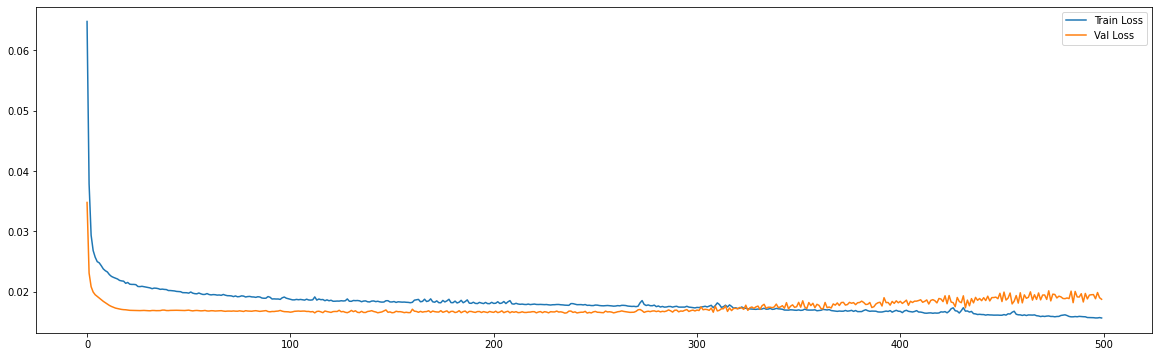

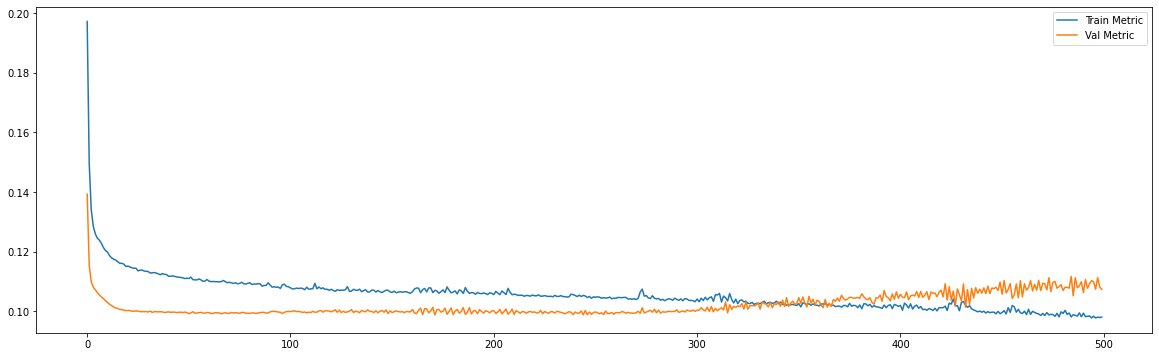



37/37 [==============================] - 0s 3ms/step - loss: 0.0153 - mae: 0.0969
loss and metric train data [0.015316260047256947, 0.09685873985290527]
7/7 [==============================] - 0s 3ms/step - loss: 0.0187 - mae: 0.1074
loss and metric val data [0.01873752847313881, 0.10738742351531982]
7/7 [==============================] - 0s 3ms/step - loss: 0.0222 - mae: 0.1157
loss and metric test data [0.02222594805061817, 0.11565031856298447]


In [48]:
regressor = Sequential()
regressor.add(LSTM(units=50, return_sequences=False, input_shape=(time_steps, n_features))) 
regressor.add(Dropout(0.2))
regressor.add(Dense(units=future_steps))

#Compiling the LSTM
adam = optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, decay = 0.0)
regressor.compile(optimizer = adam, loss = 'mse', metrics=['mae'])

#Fitting to traning set
history = regressor.fit(x_train, y_train, validation_data=(x_val,y_val), 
                        epochs = 500, batch_size=100, verbose = 0, shuffle= False)

plt.figure(figsize=(20,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train Loss', 'Val Loss'])

plt.figure(figsize=(20,6))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['Train Metric', 'Val Metric'])
plt.show()

print('\n')
print('loss and metric train data',regressor.evaluate(x_train,y_train))
print('loss and metric val data',regressor.evaluate(x_val,y_val))
print('loss and metric test data',regressor.evaluate(x_test,y_test))

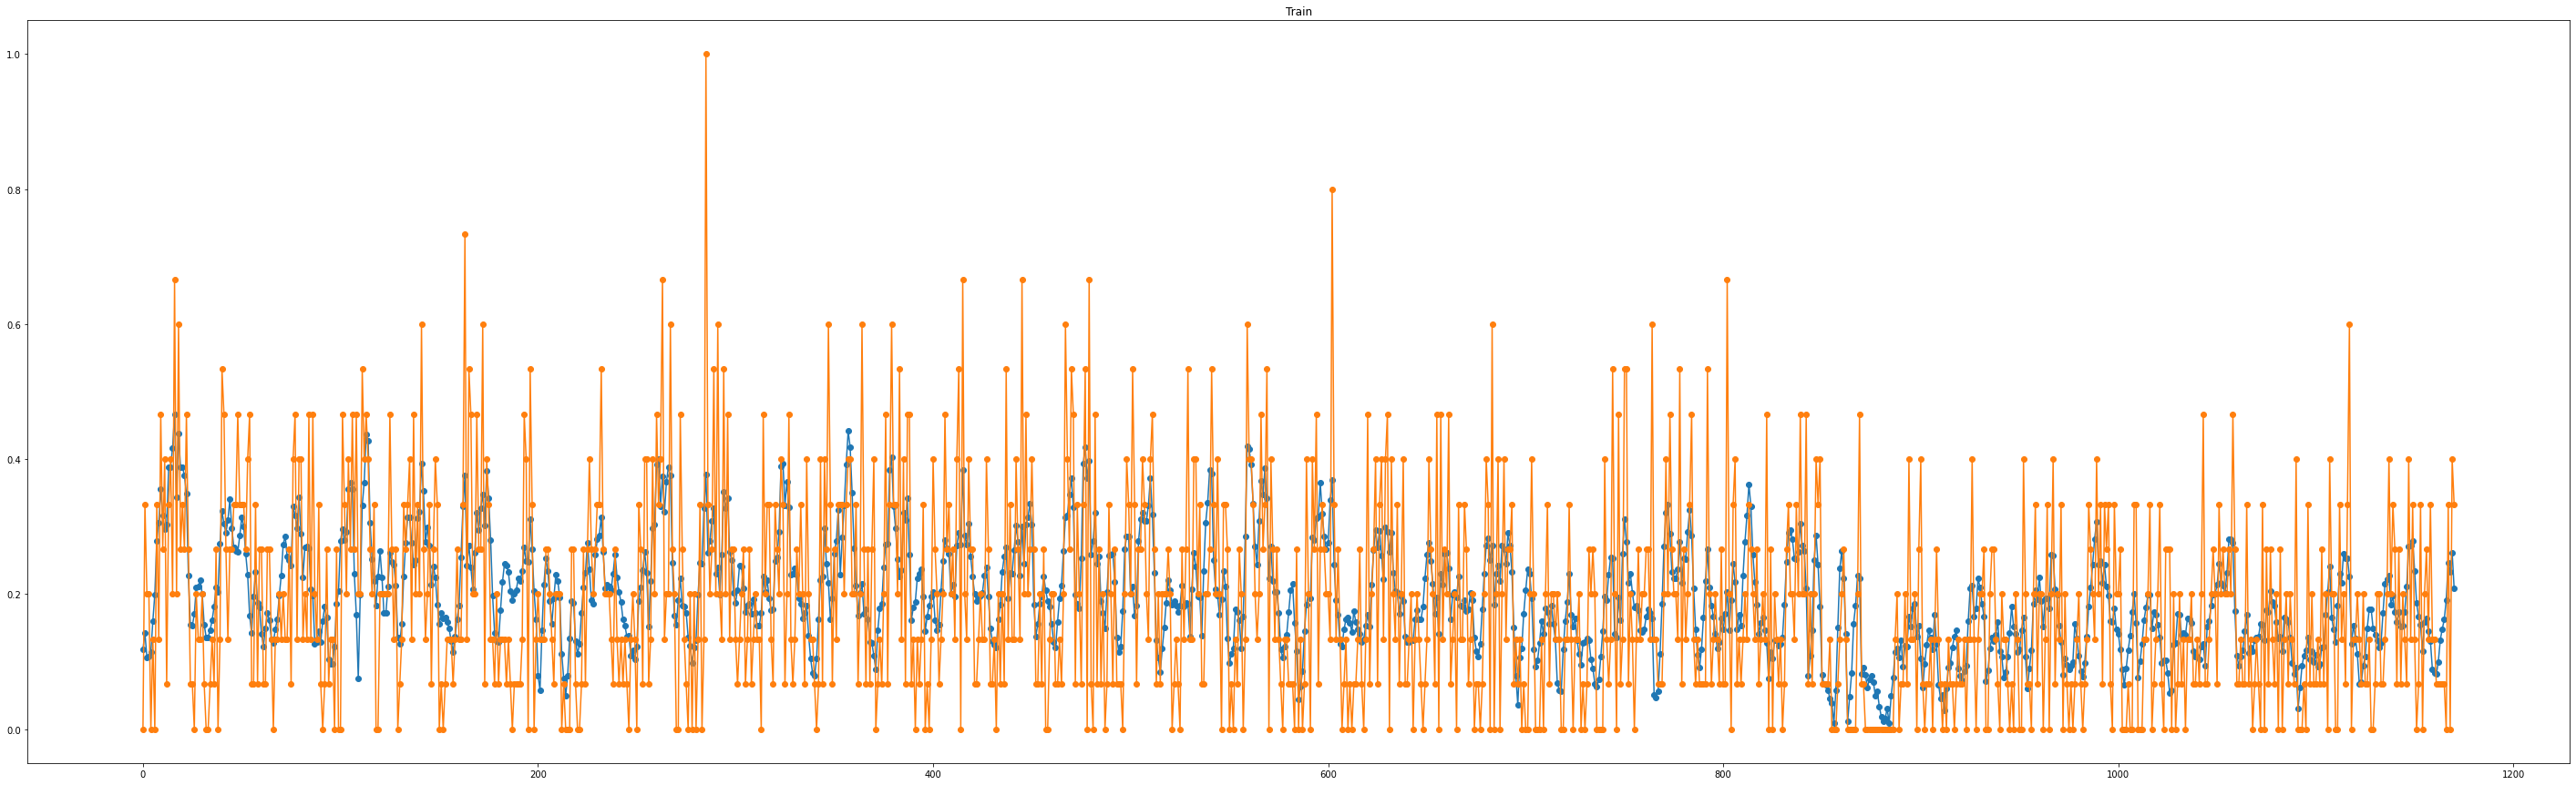

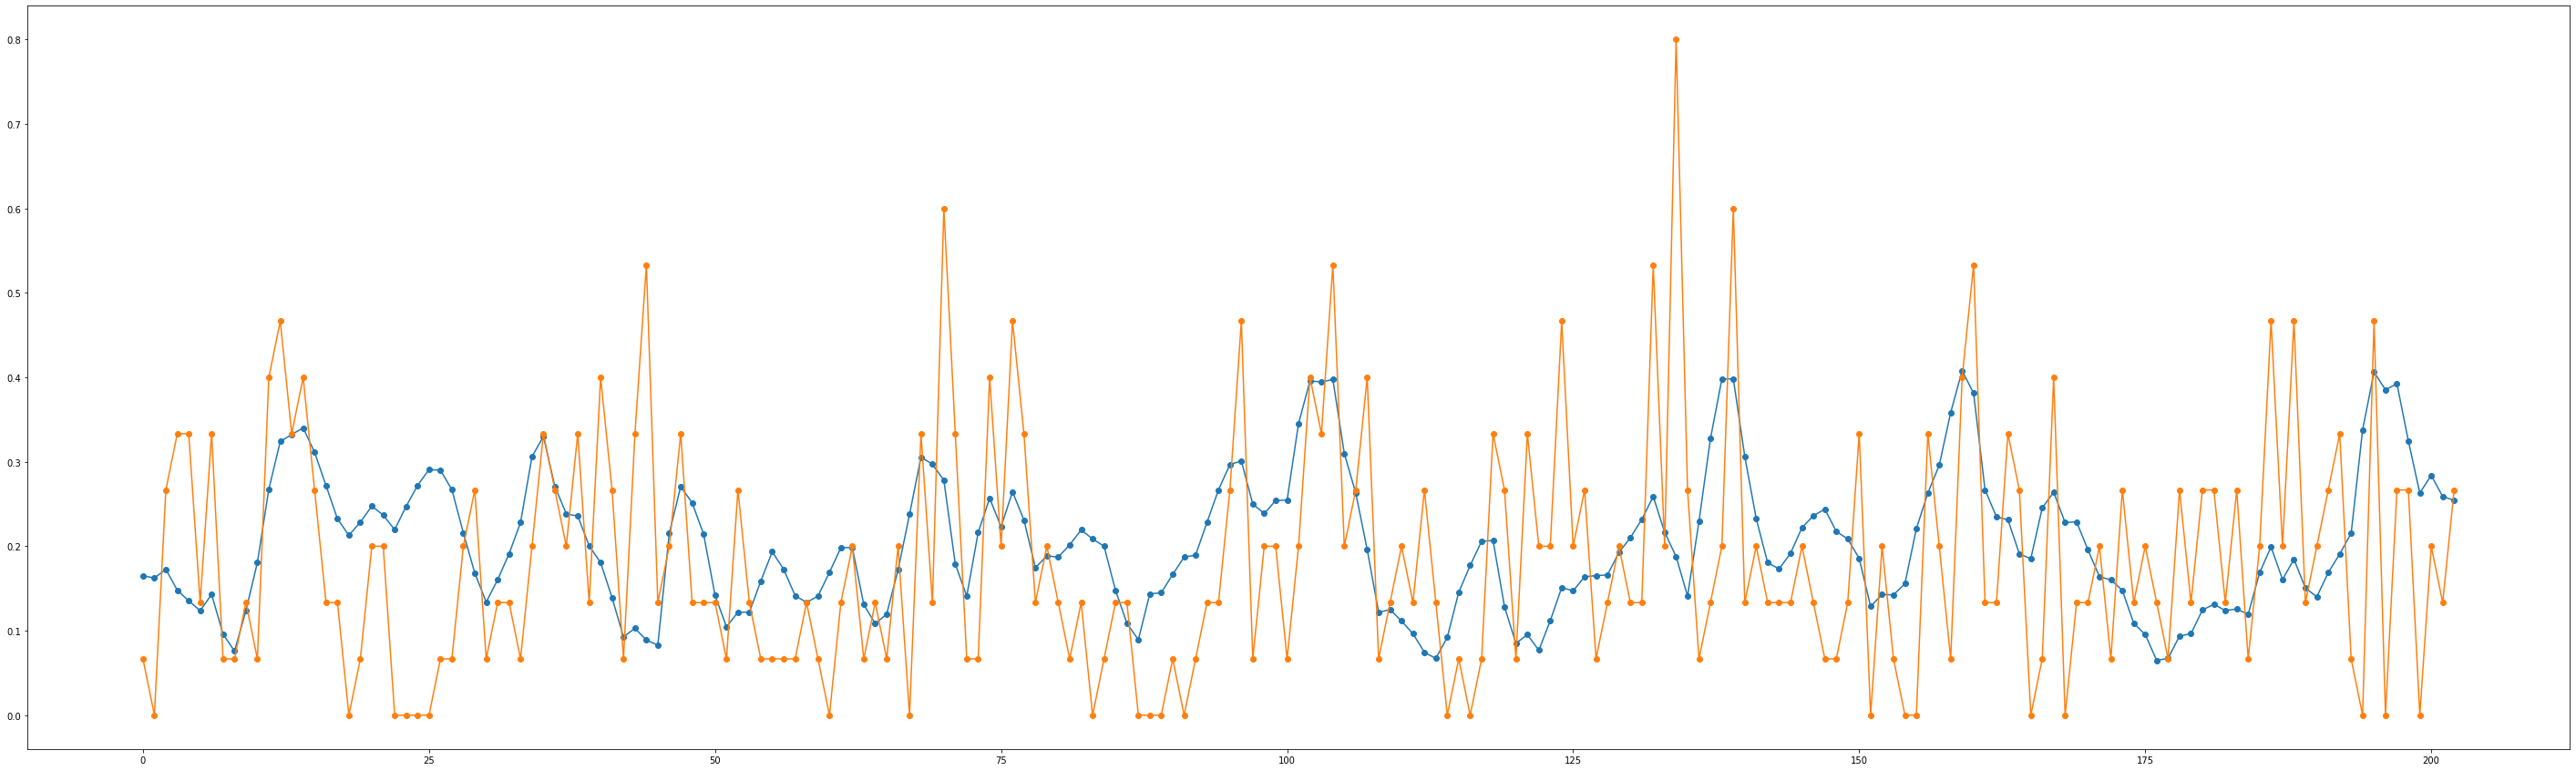

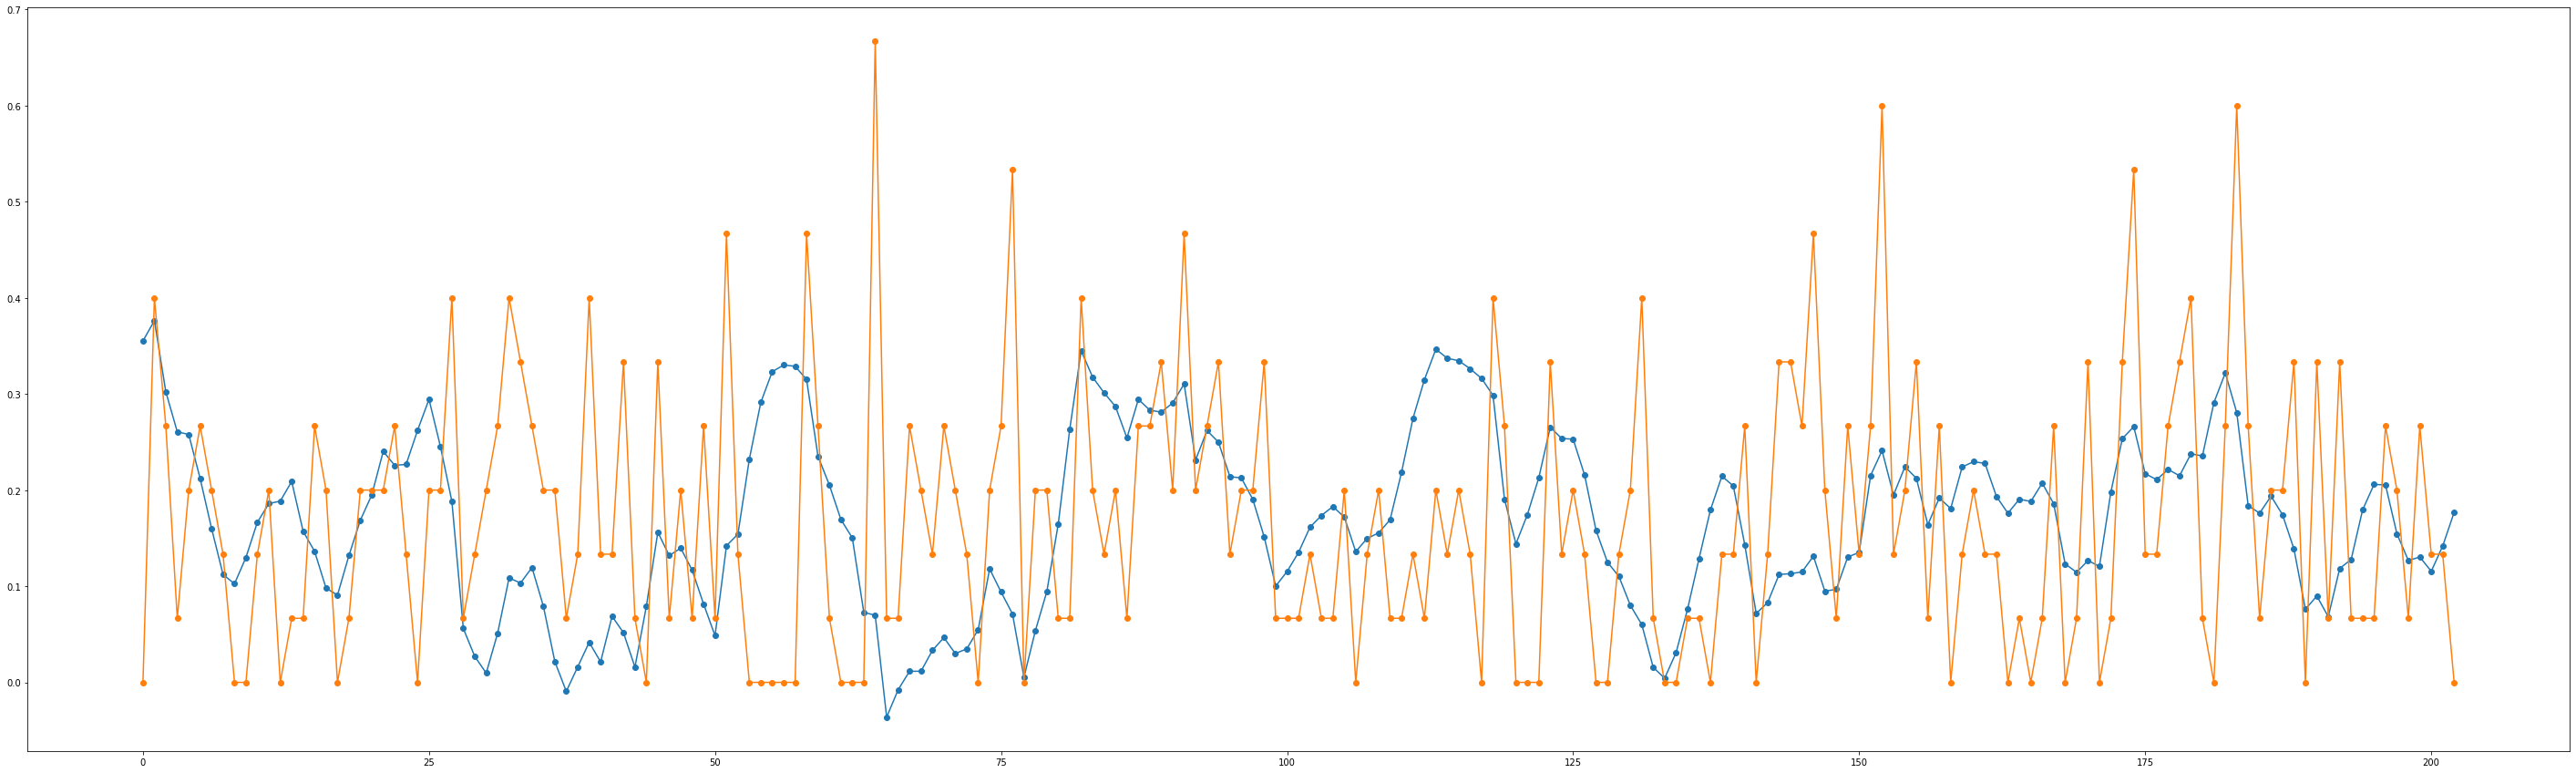

In [49]:
y_train_predict = regressor.predict(x_train)
y_val_predict = regressor.predict(x_val)
y_test_predict = regressor.predict(x_test)

plt.figure(figsize=(50,15))
plt.plot(y_train_predict[:,0],marker='o')
plt.plot(y_train[:,0],marker='o')
plt.title('Train')
plt.show()

plt.figure(figsize=(50,15))
plt.plot(y_val_predict[:,0],marker='o')
plt.plot(y_val[:,0],marker='o')

plt.figure(figsize=(50,15))
plt.plot(y_test_predict[:,0],marker='o')
plt.plot(y_test[:,0],marker='o')

In [0]:
df_test = dataset[['Sunday','snap_WI','qty_sales']].copy()

In [88]:
train_limit = int(round((df_test.shape[0])*0.7,0))
val_limit = int(round((df_test.shape[0])*0.85,0))

df_train = df_test[:train_limit]
df_val = df_test[train_limit:val_limit]
df_test = df_test[val_limit:]

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(1339, 3)
(287, 3)
(287, 3)


In [89]:
df_train

,Sunday,snap_WI,qty_sales
index,,,
d_1,0.0,0.0,1.0
d_2,1.0,0.0,2.0
d_3,0.0,0.0,4.0
d_4,0.0,0.0,2.0
d_5,0.0,1.0,3.0
...,...,...,...
d_1335,0.0,0.0,0.0
d_1336,0.0,0.0,2.0
d_1337,0.0,0.0,4.0


In [90]:
df_train_norm,df_val_norm,df_test_norm = normalizing_data(df_train,df_val,df_test)

[1. 1. 1.]
[0. 0. 0.]


[1.  1.  0.8]
[0. 0. 0.]


[1.         1.         0.66666667]
[0. 0. 0.]
-------------------------
(1339, 3)
(287, 3)
(287, 3)


In [0]:
time_steps = 84
future_steps = 28
n_features = df_train_norm.shape[1]
x_train,x_test,x_val,y_train,y_val,y_test = Regressor(future_steps = future_steps,time_steps = time_steps,n_features = n_features,df_train = df_train_norm,df_val = df_val_norm,df_test = df_test_norm)

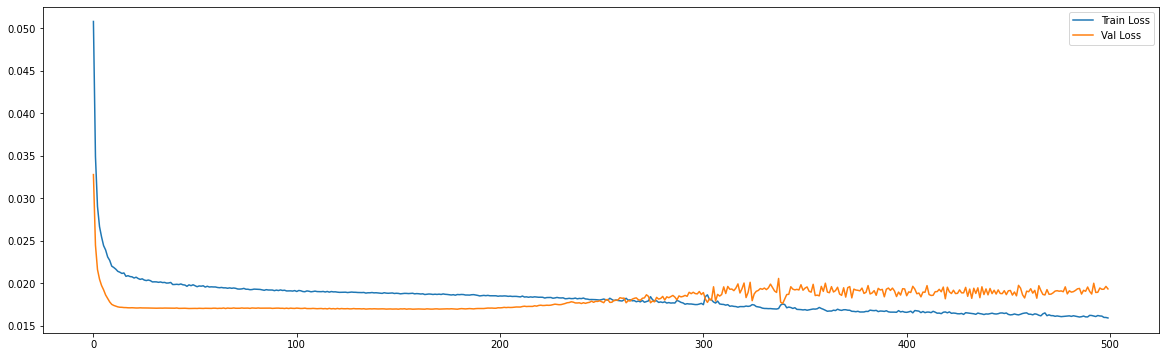

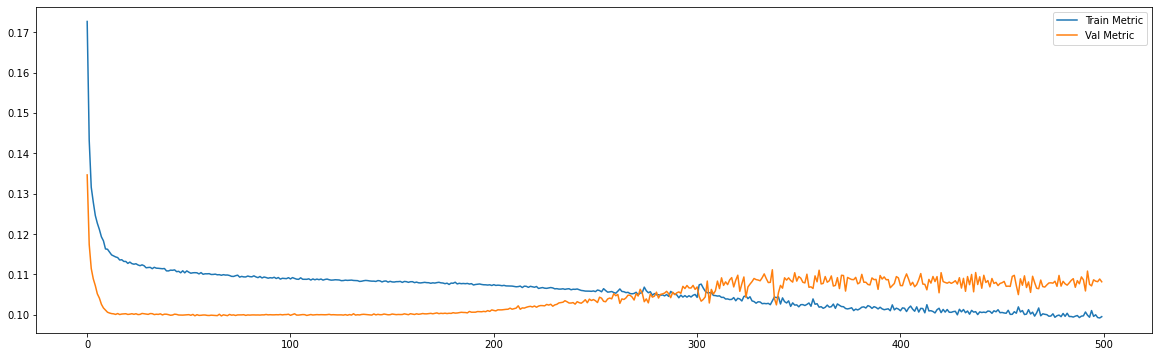



37/37 [==============================] - 0s 3ms/step - loss: 0.0155 - mae: 0.0977
loss and metric train data [0.015528247691690922, 0.09767278283834457]
7/7 [==============================] - 0s 3ms/step - loss: 0.0193 - mae: 0.1082
loss and metric val data [0.019312573596835136, 0.10817310959100723]
7/7 [==============================] - 0s 3ms/step - loss: 0.0207 - mae: 0.1142
loss and metric test data [0.020744312554597855, 0.1141812726855278]


In [92]:
regressor = Sequential()
regressor.add(LSTM(units=50, return_sequences=False, input_shape=(time_steps, n_features))) 
regressor.add(Dropout(0.2))
regressor.add(Dense(units=future_steps))

#Compiling the LSTM
adam = optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, decay = 0.0)
regressor.compile(optimizer = adam, loss = 'mse', metrics=['mae'])

#Fitting to traning set
history = regressor.fit(x_train, y_train, validation_data=(x_val,y_val), 
                        epochs = 500, batch_size=100, verbose = 0, shuffle= False)

plt.figure(figsize=(20,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train Loss', 'Val Loss'])

plt.figure(figsize=(20,6))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['Train Metric', 'Val Metric'])
plt.show()

print('\n')
print('loss and metric train data',regressor.evaluate(x_train,y_train))
print('loss and metric val data',regressor.evaluate(x_val,y_val))
print('loss and metric test data',regressor.evaluate(x_test,y_test))

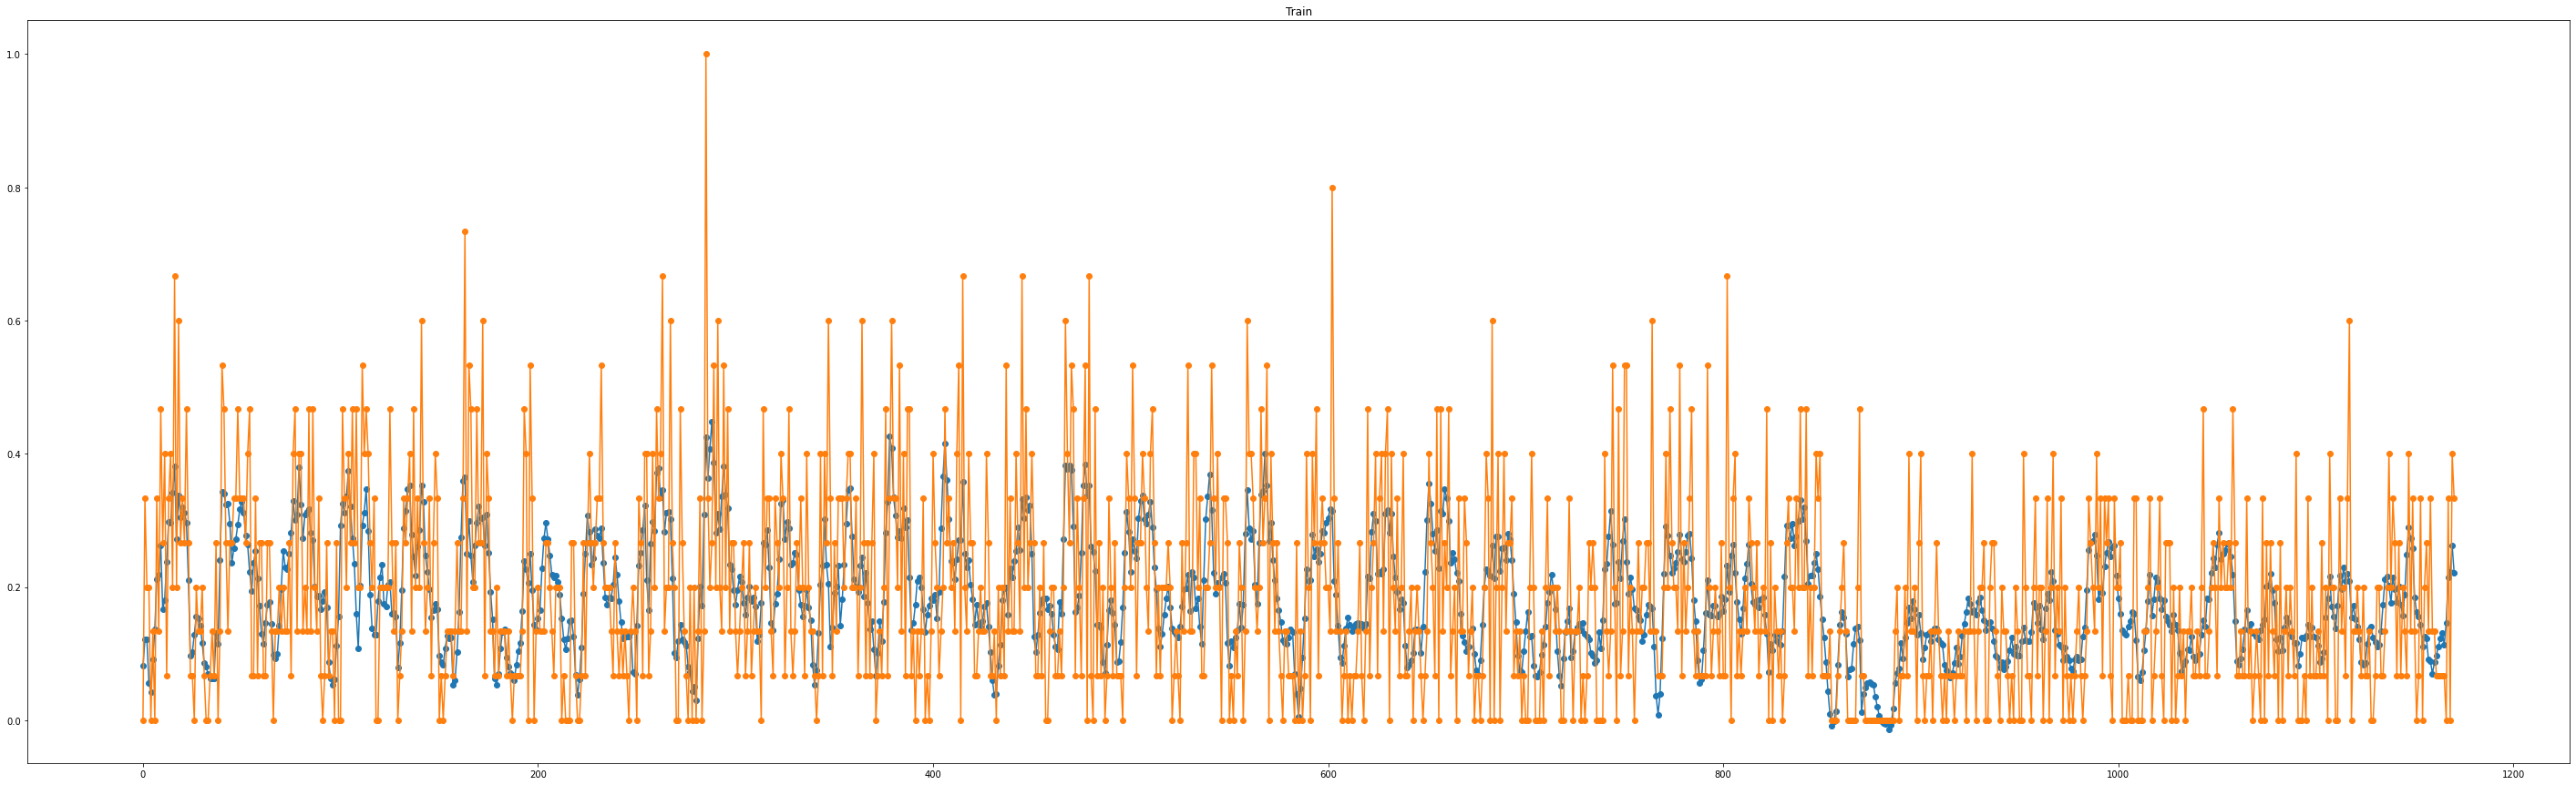

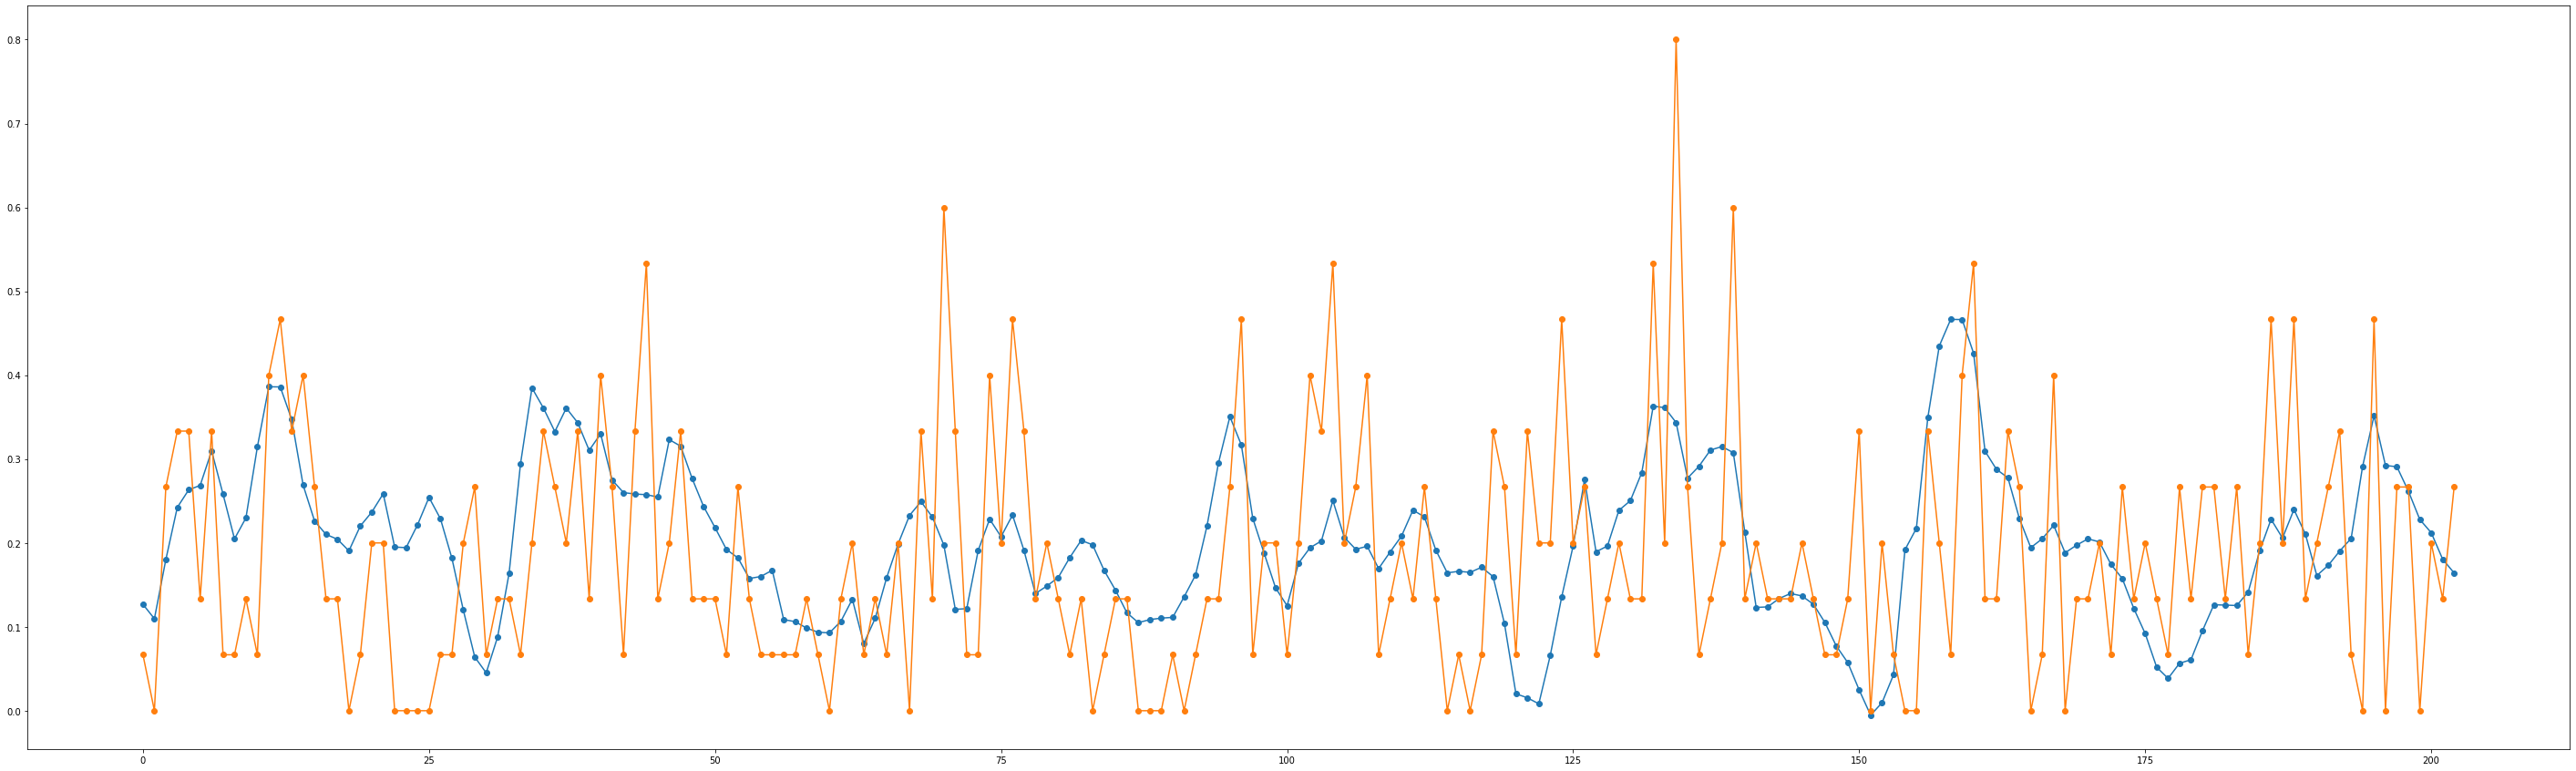

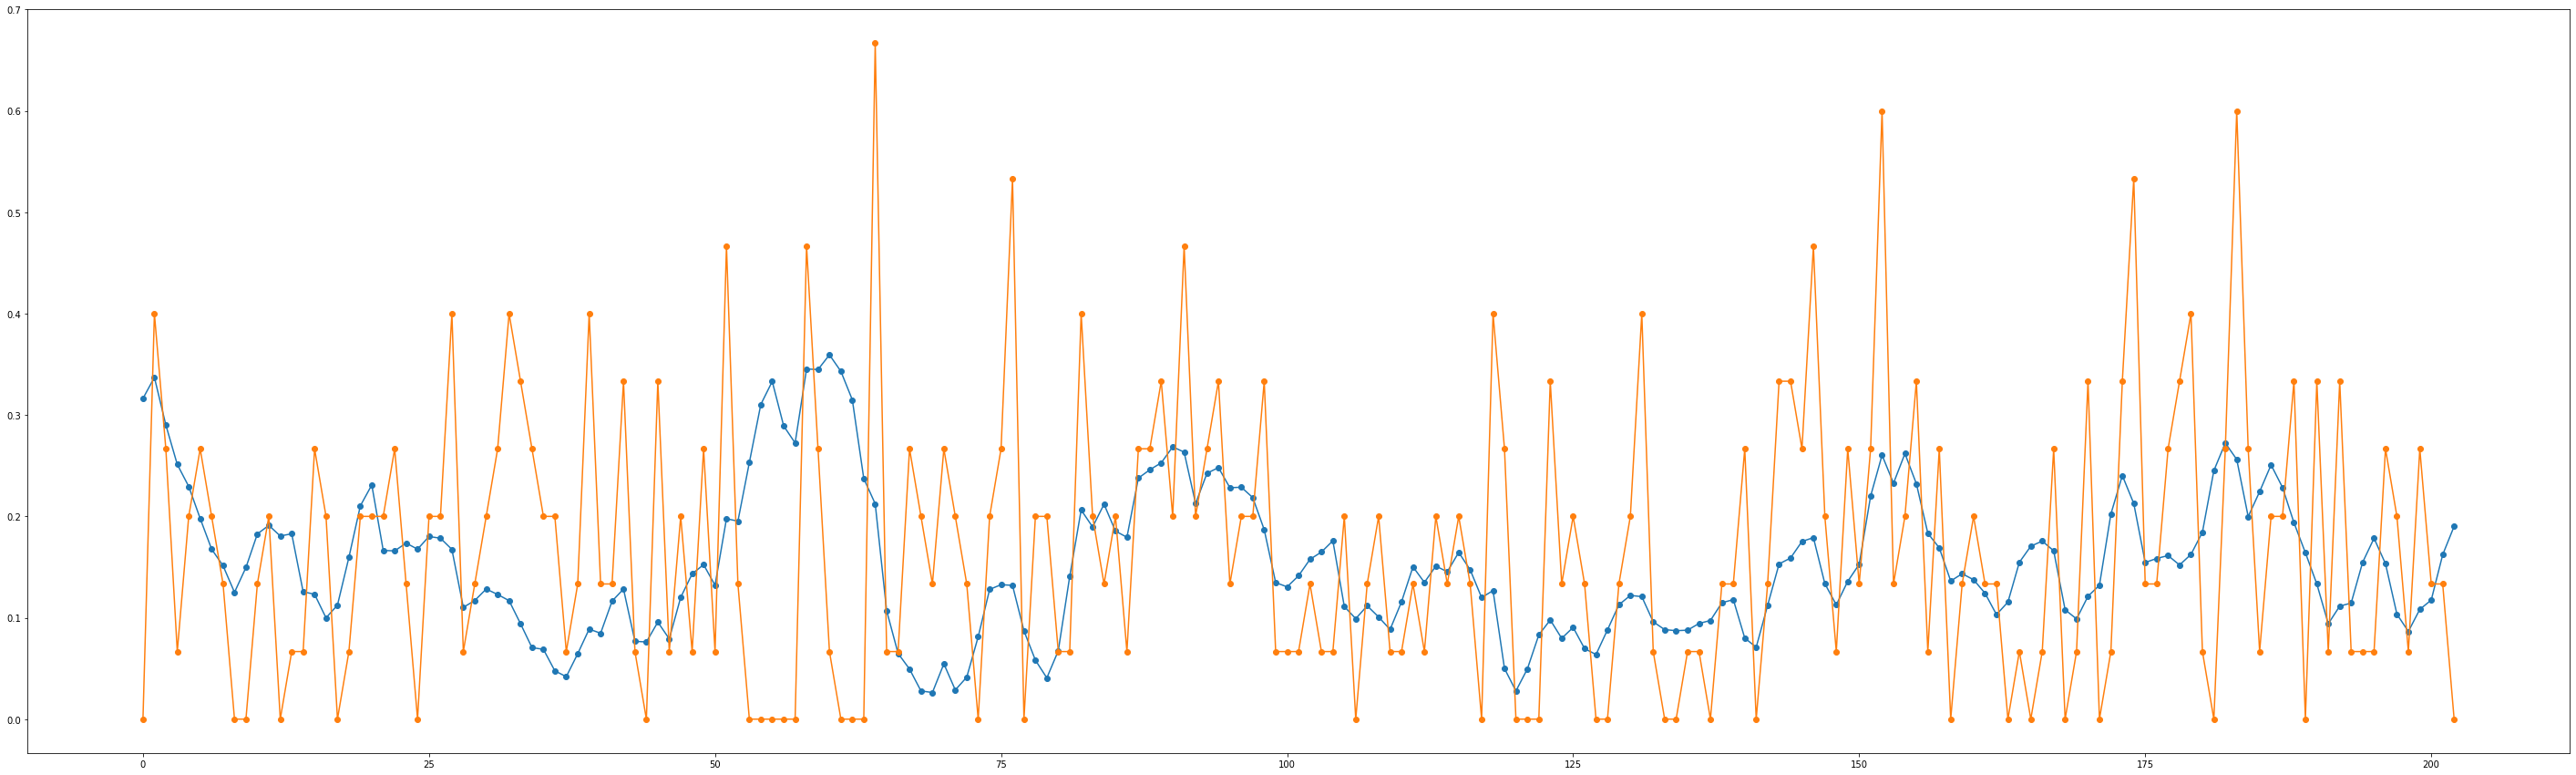

In [93]:
y_train_predict = regressor.predict(x_train)
y_val_predict = regressor.predict(x_val)
y_test_predict = regressor.predict(x_test)

plt.figure(figsize=(50,15))
plt.plot(y_train_predict[:,0],marker='o')
plt.plot(y_train[:,0],marker='o')
plt.title('Train')
plt.show()

plt.figure(figsize=(50,15))
plt.plot(y_val_predict[:,0],marker='o')
plt.plot(y_val[:,0],marker='o')

plt.figure(figsize=(50,15))
plt.plot(y_test_predict[:,0],marker='o')
plt.plot(y_test[:,0],marker='o')